<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [3]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [5]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-11-20 07:33:41--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.1s    

2020-11-20 07:33:41 (226 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [6]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [7]:
df.shape

(346, 10)

### Convert to date time object 

In [8]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [9]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [1]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

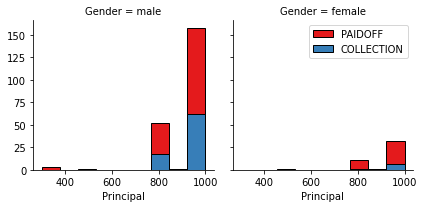

In [10]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

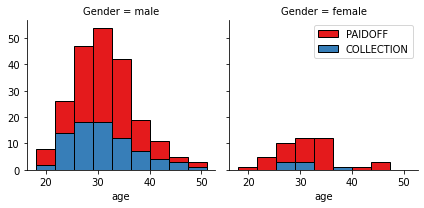

In [11]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

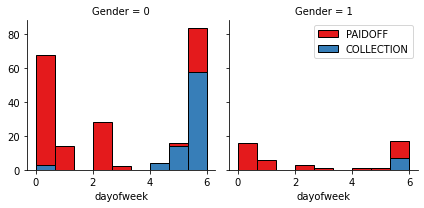

In [18]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [19]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [20]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
0       PAIDOFF        0.731293
        COLLECTION     0.268707
1       PAIDOFF        0.865385
        COLLECTION     0.134615
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [31]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [22]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [23]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [24]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [124]:
X = Feature
X[0:7]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1
5,1000,30,36,0,1,0,0,1
6,1000,30,28,0,1,0,0,1


What are our lables?

In [57]:
y = df['loan_status'].values
y[0:5]

#Convert to binary. 1 for loan default
y_bin = pd.get_dummies(y)
y_bin.drop(['PAIDOFF'],axis=1,inplace = True)
y_bin = y_bin.values.ravel()
y_bin.shape

(346,)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [27]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [58]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split( X, y_bin, test_size=0.2, random_state=4)
print ('Train set:', X1_train.shape,  Y1_train.shape)
print ('Test set:', X1_test.shape,  Y1_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X1_train,Y1_train)
yhat1 = neigh.predict(X1_test)
yhat1[0:5]

array([0, 0, 0, 0, 0], dtype=uint8)

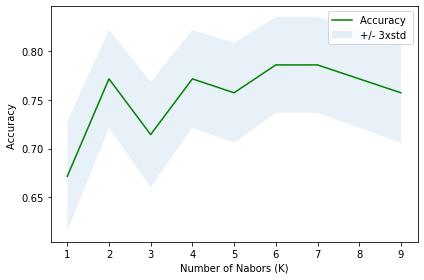

The best accuracy was with 0.7857142857142857 with k= 6


In [171]:
#Testing for best value of K

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X1_train,Y1_train)
    yhat=neigh.predict(X1_test)
    mean_acc[n-1] = metrics.accuracy_score(Y1_test, yhat)
    
    
    std_acc[n-1]=np.std(yhat==Y1_test)/np.sqrt(yhat.shape[0])

mean_acc

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

print("The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)
#Using best value of k=6
neigh = KNeighborsClassifier(n_neighbors = 6).fit(X,y_bin)

# Decision Tree

In [172]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
#No need to standarise the feature variables for ease of readability
X2_train, X2_test, Y2_train, Y2_test = train_test_split(Feature, y_bin, test_size=0.2, random_state=4)

loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree.fit(X2_train,Y2_train)
predTree=loanTree.predict(X2_test)
metrics.accuracy_score(Y2_test, predTree)

0.7857142857142857

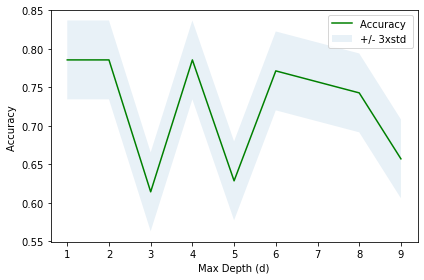

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [173]:
#Find best value for max depth
d=10
for n in range(1,d):
    
    #Train Model and Predict  
    tempTree = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X2_train,Y2_train)
    yhat2=tempTree.predict(X2_test)
    mean_acc[n-1] = metrics.accuracy_score(Y2_test, yhat2)
    
    
    std_acc[n-1]=np.std(yhat==Y1_test)/np.sqrt(yhat.shape[0])

mean_acc
plt.plot(range(1,d),mean_acc,'g')
plt.fill_between(range(1,d),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Max Depth (d)')
plt.tight_layout()
plt.show()

#Selecting d = 4 as max depth
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree.fit(Feature,y_bin)


[Text(313.875, 978.48, 'weekend <= 0.5\nentropy = 0.809\nsamples = 346\nvalue = [260, 86]\nclass = Paidoff'),
 Text(139.5, 761.0400000000001, 'college <= 0.5\nentropy = 0.149\nsamples = 141\nvalue = [138, 3]\nclass = Paidoff'),
 Text(69.75, 543.6, 'entropy = 0.0\nsamples = 84\nvalue = [84, 0]\nclass = Paidoff'),
 Text(209.25, 543.6, 'Gender <= 0.5\nentropy = 0.297\nsamples = 57\nvalue = [54, 3]\nclass = Paidoff'),
 Text(139.5, 326.1600000000001, 'age <= 25.5\nentropy = 0.342\nsamples = 47\nvalue = [44, 3]\nclass = Paidoff'),
 Text(69.75, 108.72000000000003, 'entropy = 0.0\nsamples = 7\nvalue = [7, 0]\nclass = Paidoff'),
 Text(209.25, 108.72000000000003, 'entropy = 0.384\nsamples = 40\nvalue = [37, 3]\nclass = Paidoff'),
 Text(279.0, 326.1600000000001, 'entropy = 0.0\nsamples = 10\nvalue = [10, 0]\nclass = Paidoff'),
 Text(488.25, 761.0400000000001, 'terms <= 11.0\nentropy = 0.974\nsamples = 205\nvalue = [122, 83]\nclass = Paidoff'),
 Text(418.5, 543.6, 'entropy = 0.0\nsamples = 7\nvalu

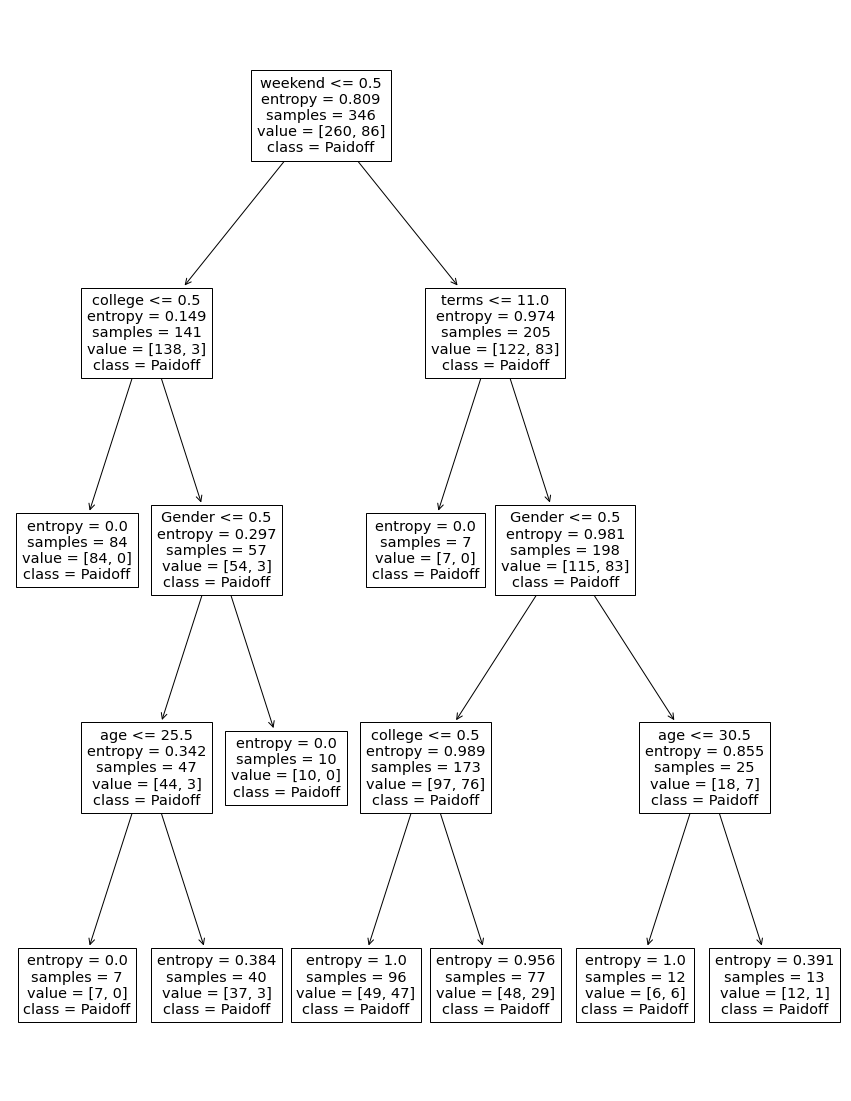

In [92]:
#Plotting the tree
plt.figure(figsize=(15, 20))
featureNames = Feature.columns[0:8].tolist()
tree.plot_tree(loanTree,feature_names=featureNames,class_names=['Paidoff','Collection'])

# Support Vector Machine

In [98]:
#SVM works better with standarised data
from sklearn import svm
from sklearn.metrics import f1_score

#Finding best kernel
clf = svm.SVC(kernel='rbf')
clf.fit(X1_train, Y1_train) 
print("F1 Score with RBF:", f1_score(Y1_test, clf.predict(X1_test), average='weighted'))


clf = svm.SVC(kernel='linear')
clf.fit(X1_train, Y1_train) 
print("F1 Score with linear:", f1_score(Y1_test, clf.predict(X1_test), average='weighted'))

clf = svm.SVC(kernel='poly')
clf.fit(X1_train, Y1_train) 
print("F1 Score with poly:", f1_score(Y1_test, clf.predict(X1_test), average='weighted'))

clf = svm.SVC(kernel='sigmoid')
clf.fit(X1_train, Y1_train) 
print("F1 Score with sigmoid:", f1_score(Y1_test, clf.predict(X1_test), average='weighted'))

#RBF gives best results
clf = svm.SVC(kernel='rbf')
clf.fit(X, y_bin) 


F1 Score with RBF: 0.7275882012724117
F1 Score with linear: 0.6914285714285714
F1 Score with poly: 0.7064793130366899
F1 Score with sigmoid: 0.6953867388649997


SVC()

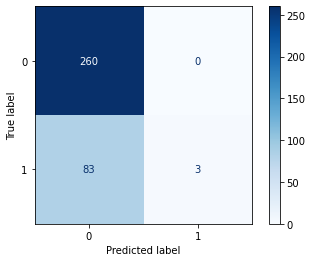

In [105]:
#Plotting confusion matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X, y_bin, cmap=plt.cm.Blues)

# Logistic Regression

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


LR1 = LogisticRegression(C=0.1, solver='lbfgs').fit(X1_train,Y1_train)
yhat3 = LR1.predict(X1_test)
print(classification_report(Y1_test, yhat3))

LR2 = LogisticRegression(C=0.1, solver='liblinear').fit(X1_train,Y1_train)
yhat3 = LR2.predict(X1_test)
print(classification_report(Y1_test, yhat3))

LR3 = LogisticRegression(C=0.1, solver='newton-cg').fit(X1_train,Y1_train)
yhat3 = LR3.predict(X1_test)
print(classification_report(Y1_test, yhat3))

LR4 = LogisticRegression(C=0.1, solver='saga').fit(X1_train,Y1_train)
yhat3 = LR4.predict(X1_test)
print(classification_report(Y1_test, yhat3))
#saga,lbfgs and newton-cg perform similar will will use lbfgs here



              precision    recall  f1-score   support

           0       0.79      0.96      0.87        55
           1       0.33      0.07      0.11        15

    accuracy                           0.77        70
   macro avg       0.56      0.52      0.49        70
weighted avg       0.69      0.77      0.71        70

              precision    recall  f1-score   support

           0       0.79      0.91      0.85        55
           1       0.29      0.13      0.18        15

    accuracy                           0.74        70
   macro avg       0.54      0.52      0.51        70
weighted avg       0.68      0.74      0.70        70

              precision    recall  f1-score   support

           0       0.79      0.96      0.87        55
           1       0.33      0.07      0.11        15

    accuracy                           0.77        70
   macro avg       0.56      0.52      0.49        70
weighted avg       0.69      0.77      0.71        70

              preci

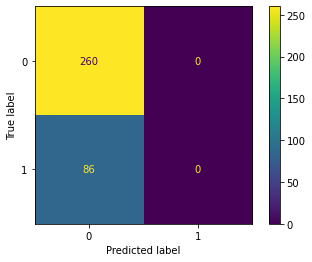

In [145]:
LR = LogisticRegression(C=0.1, solver='lbfgs').fit(X,y_bin)
plot_confusion_matrix(LR,X,y_bin)

# Model Evaluation using Test set

In [146]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [134]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-11-20 10:26:02--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-11-20 10:26:03 (45.5 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [181]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [182]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()
testFeature = test_df[['Principal','terms','age','Gender','weekend']]
testFeature = pd.concat([testFeature,pd.get_dummies(test_df['education'])], axis=1)
testFeature.drop(['Master or Above'], axis = 1,inplace=True)
testFeature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [185]:
X_test = testFeature
X_test= preprocessing.StandardScaler().fit(X_test).transform(X_test)

y_test = test_df['loan_status'].values
#Convert to binary. 1 for loan default
y_bin_test = pd.get_dummies(y_test)
y_bin_test.drop(['PAIDOFF'],axis=1,inplace = True)
y_bin_test = y_bin_test.values.ravel()
y_bin_test.shape

(54,)

In [190]:
#Predictions
yhatKNN = neigh.predict(X_test)
yhatDT = loanTree.predict(X_test)
yhatSVM = clf.predict(X_test)
yhatLogReg = LR.predict(X_test)

#Jaccard Scores
print("Jaccard Score for KNN: ", jaccard_score(y_bin_test, yhatKNN))
print("Jaccard Score for DT: ", jaccard_score(y_bin_test, yhatDT))
print("Jaccard Score for SVM: ", jaccard_score(y_bin_test, yhatSVM))
print("Jaccard Score for LR: ", jaccard_score(y_bin_test, yhatLogReg))

#F1 Scores
print("F1 Score for KNN: ", f1_score(y_bin_test, yhatKNN, average = 'weighted'))
print("F1 Score for DT: ", f1_score(y_bin_test, yhatDT,average = 'weighted'))
print("F1 for SVM: ", f1_score(y_bin_test, yhatSVM , average = 'weighted'))
print("F1 for LR: ", f1_score(y_bin_test, yhatLogReg, average = 'weighted'))


#LogLoss
print("Log Loss for LR: ", log_loss(y_bin_test, yhatLogReg))


Jaccard Score for KNN:  0.0
Jaccard Score for DT:  0.0
Jaccard Score for SVM:  0.0
Jaccard Score for LR:  0.3939393939393939
F1 Score for KNN:  0.6304176516942475
F1 Score for DT:  0.6304176516942475
F1 for SVM:  0.6212664277180406
F1 for LR:  0.6483299568853568
Log Loss for KNN:  8.954497583865733
Log Loss for DT:  8.954497583865733
Log Loss for SVM:  9.594119361501672
Log Loss for LR:  12.792420745359026


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>